# Employee Attrition study

Employee attrition is a serious problem for a company, maintining its top talents can lead to a great reduction in costs.

Given that the employee's productivity tends to diminish when they decide to leave the company and given that there's an overhead cost in replacing an employee and giving him the propper formation and time to adjust to the new position, it's safe to say that this is a costly event. Granted not all attritions are bad, some employees are just disrupting, but in general maintining the maximum number of employees as possible is a sound strategy, as described [here](https://inventiv.io/what-is-the-cost-of-replacing-an-employee/), [here](https://www.employeeconnect.com/blog/flight-risk-signals-what-makes-employees-leave/) and [here](http://analytics-magazine.org/predictive-analytics-the-privacy-pickle-hewlett-packards-prediction-of-employee-behavior/)

Given this context we'll try to create a model to predict who's about to leave the company so we could report it to HR and they can decid to do something about it

# Table Of Contents
 1. Exploratory Data Analysis
 2. Feature Selection
 3. Modeling
 4. Interpreting results

In [2]:
# Loading required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif

# Loading the dataset
df = pd.read_csv("../input/WA_Fn-UseC_-HR-Employee-Attrition.csv")

print(df.shape)
df.head()

(1470, 35)


Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

Great! we got our dataset loaded, let's do a quick check to see how many missing values we're dealing with

In [3]:
df.isna().count()

Age                         1470
Attrition                   1470
BusinessTravel              1470
DailyRate                   1470
Department                  1470
DistanceFromHome            1470
Education                   1470
EducationField              1470
EmployeeCount               1470
EmployeeNumber              1470
EnvironmentSatisfaction     1470
Gender                      1470
HourlyRate                  1470
JobInvolvement              1470
JobLevel                    1470
JobRole                     1470
JobSatisfaction             1470
MaritalStatus               1470
MonthlyIncome               1470
MonthlyRate                 1470
NumCompaniesWorked          1470
Over18                      1470
OverTime                    1470
PercentSalaryHike           1470
PerformanceRating           1470
RelationshipSatisfaction    1470
StandardHours               1470
StockOptionLevel            1470
TotalWorkingYears           1470
TrainingTimesLastYear       1470
WorkLifeBa

It seems to be no missing values, which is perfect! we'll go ahead and get familiarized with the dataset

# 1. Exploratory data analysis
This section aims to explorate the data a bit, try to get a feel of the problem and maybe find some key insights that might be useful later on

First of all, lets let's just see the number of people who left and who didn't

In [4]:
# Create just a simple lambda to calculate the proportion of each group 
prop_func = lambda x: round(len(x) / df.shape[0], 5) * 100

df.groupby("Attrition")["Attrition"].agg(["count", prop_func])

count  <lambda>
Attrition                 
No          1233    83.878
Yes          237    16.122

So we have 237 cases of employees who left the company which is around 16,122% of the entire dataset, this means that our classes are fairly **inbalanced**, so we'll see some ways to work around this issue

Let's continue with our analysis

## Whats the age distribution on each group?

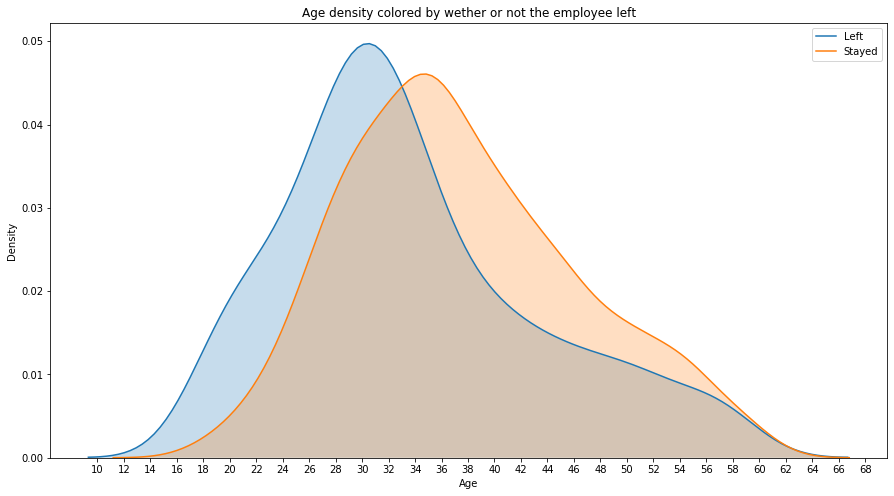

In [5]:
f,ax = plt.subplots(figsize=(15,8))
sns.kdeplot(df.loc[df.Attrition == "Yes", "Age"], shade = True, label = "Left")
sns.kdeplot(df.loc[df.Attrition == "No", "Age"], shade = True, label = "Stayed")
ax.set(xlabel = "Age", ylabel = "Density",title = "Age density colored by wether or not the employee left")
ax.set_xticks(range(10, 70, 2))
plt.show()

So it appears younger people tend to leave the company more often which is to be expected since they probably haven't settled on a house/family or they might get more job offerings. This feature is probably a good feature to use in our model

Note: don't worry there are no 10 year-olds working in this company, its just the way the kde plots this graph (:

## Which gender is more likely to leave?

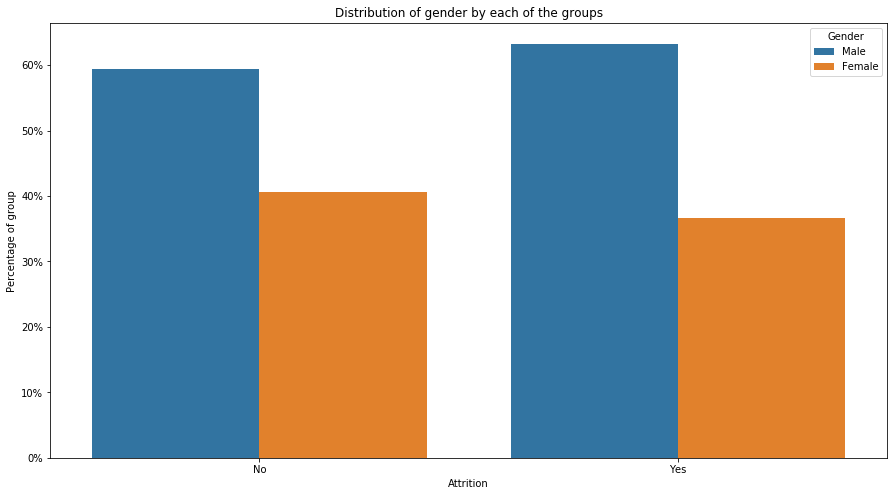

In [6]:
f,ax = plt.subplots(figsize=(15,8))

# Get the proportion of the genders grouped by the attrition status
grouped_data = df["Gender"].groupby(df["Attrition"]).value_counts(normalize = True).rename("Percentage of group").reset_index()

# Plot the result
sns.barplot(x = "Attrition", y = "Percentage of group", hue = "Gender", data = grouped_data)

# Convert y axis to percentage format
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

ax.set(title = "Distribution of gender by each of the groups")
plt.show()

This company has more men the women and so this plot shows us that men tend to leave the company more but only because they're in a larger number. This also indicates that gender might not be a key factor for employee attrition

## Are leavers more dissatisfied with their jobs?

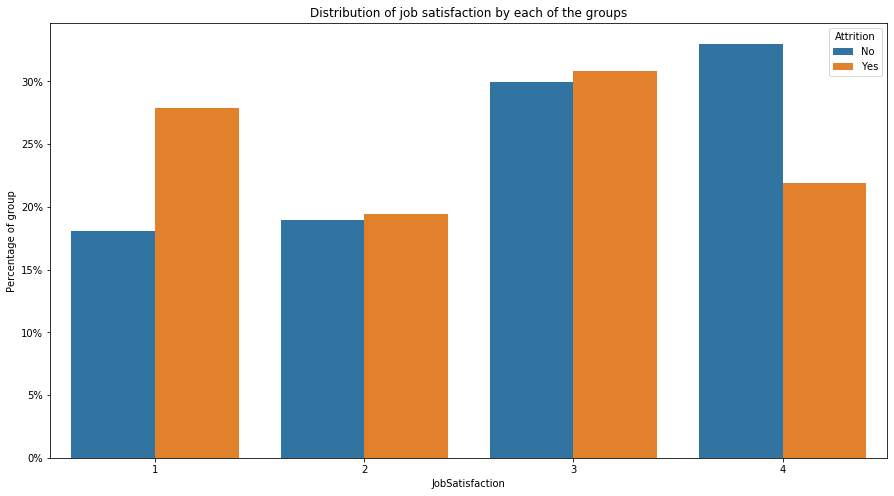

In [7]:
f,ax = plt.subplots(figsize=(15,8))
grouped_data = df["JobSatisfaction"].groupby(df["Attrition"]).value_counts(normalize = True).rename("Percentage of group").reset_index()
sns.barplot(x = "JobSatisfaction", y = "Percentage of group", hue = "Attrition", data = grouped_data)

# Convert y axis to percentage format
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

ax.set(title = "Distribution of job satisfaction by each of the groups")
plt.show()

It appears to be so. Around 27% of people who left the company felt really dissatisfied with their jobs, while only nearly 17% of people who stayed said the same thing.

In contrast people who stay in the company seem to be, in general, satisfied with their jobs.

It's also interesting to see there's a large portion of leavers that have a level 3 of satisfaction. This might be either because of the scoring mechanism (i.e, 3 is a somewhat neutral job statisfaction level) or they're cases where a person does not leave the job because they don't like it but maybe they received a better offer

## Do people who leave tend to have more overtime?

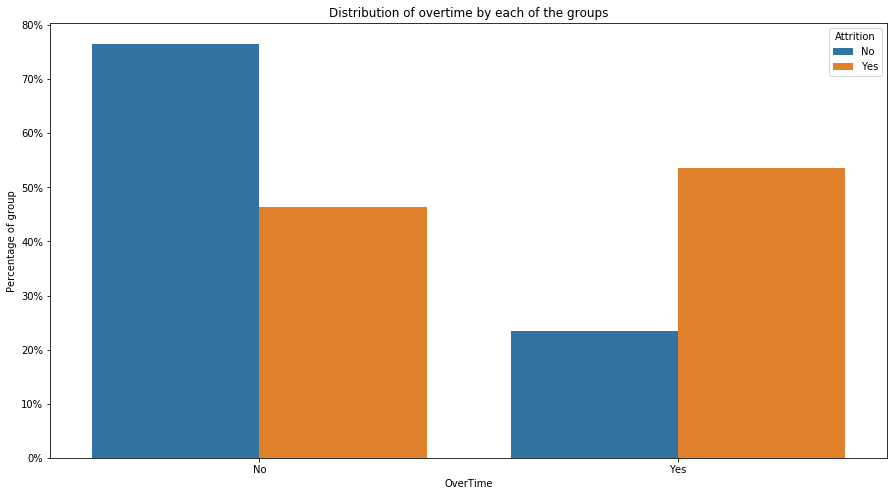

In [8]:
f,ax = plt.subplots(figsize=(15,8))
grouped_data = df["OverTime"].groupby(df["Attrition"]).value_counts(normalize = True).rename("Percentage of group").reset_index()
sns.barplot(x = "OverTime", y = "Percentage of group", hue = "Attrition", data = grouped_data)

# Convert y axis to percentage format
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

ax.set(title = "Distribution of overtime by each of the groups")
plt.show()

So there's a near 50-50 split in people who leave the company reagarding overtime, meaning some work overtime and some don't.

But the finding we can take from here is that just a small portion (around 27%) of people who stay in the company work overtime. Meaning this might be another usefull feature for our model, if an observation states that a person works overtime we'll be more inclined to say that this person is likely to leave the company (so go ahead and tell your bosses you're not working overtime because you don't want to leave the company (: )

There's many more plots we could make to answer some basic questions like these ones, but these visualizations are only one-dimensional (for each attrition group) so, although they're helpful, we might get some extra information when we see the relation between two or more variables

## Age vs monthly income with salary hike controling the size

This is a good company to be in since everyone got a increase in it's salary, but some received more than others, let's look at what's the relation between the age and the monthly income and let's make the points bigger where a person received a salary hike above the average (which is around 15%)

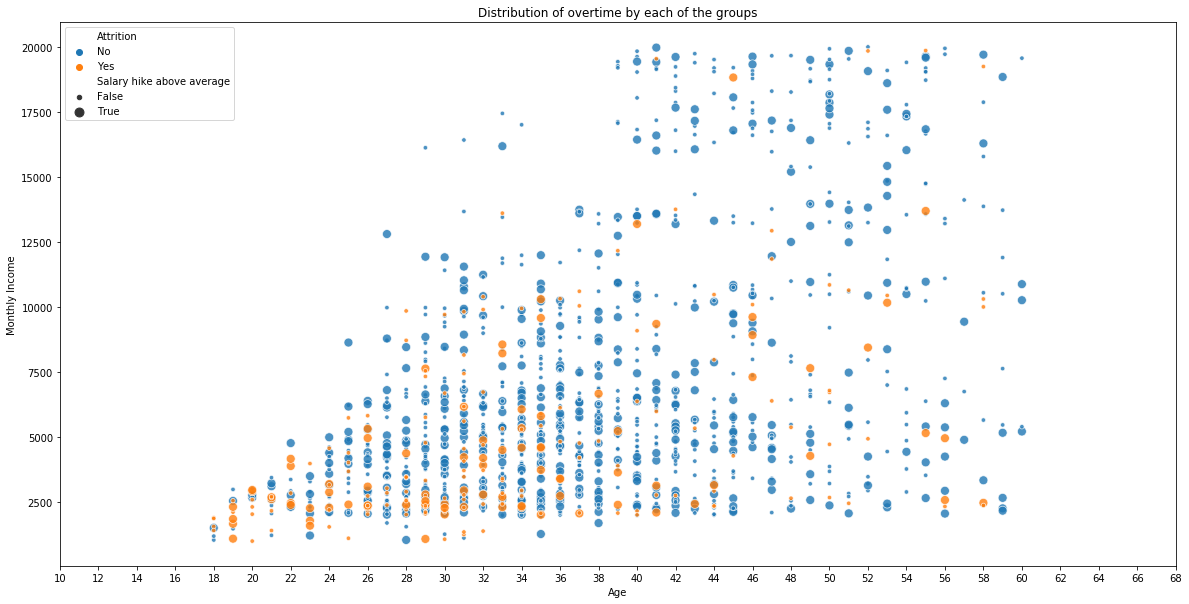

In [9]:
df["Salary hike above average"] = df.PercentSalaryHike > df.PercentSalaryHike.mean()

df_reordered = df.sort_values(by=['Attrition'])

f,ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(x="Age", y="MonthlyIncome", hue="Attrition", size = "Salary hike above average", data=df_reordered, alpha = 0.8, sizes = (80,20))
ax.set(ylabel = "Monthly Income", title = "Distribution of overtime by each of the groups")
ax.set_xticks(range(10, 70, 2))
plt.show()

Okay so there's a lot of stuff here (maybe too much, ups) but lets break it down:

1. We can see that leavers are in the younger age group (as we saw before) but we actually see that they tend to have lower sallaries then persons who stayed in the company

2. As a person gets older they tend to get a higher monthly income (probably because their tenure in the company increases as well)

3. It appears that receiving a salary hike above the average has no effect on making a person stay in the company since the're so many leavers with above average salary hikes

4. This effect might only be noticeable for persons with higher monthly incomes (above 10000) but more investigation would be needed to say the for certain

lastly let's just see the overall correlation between the variables

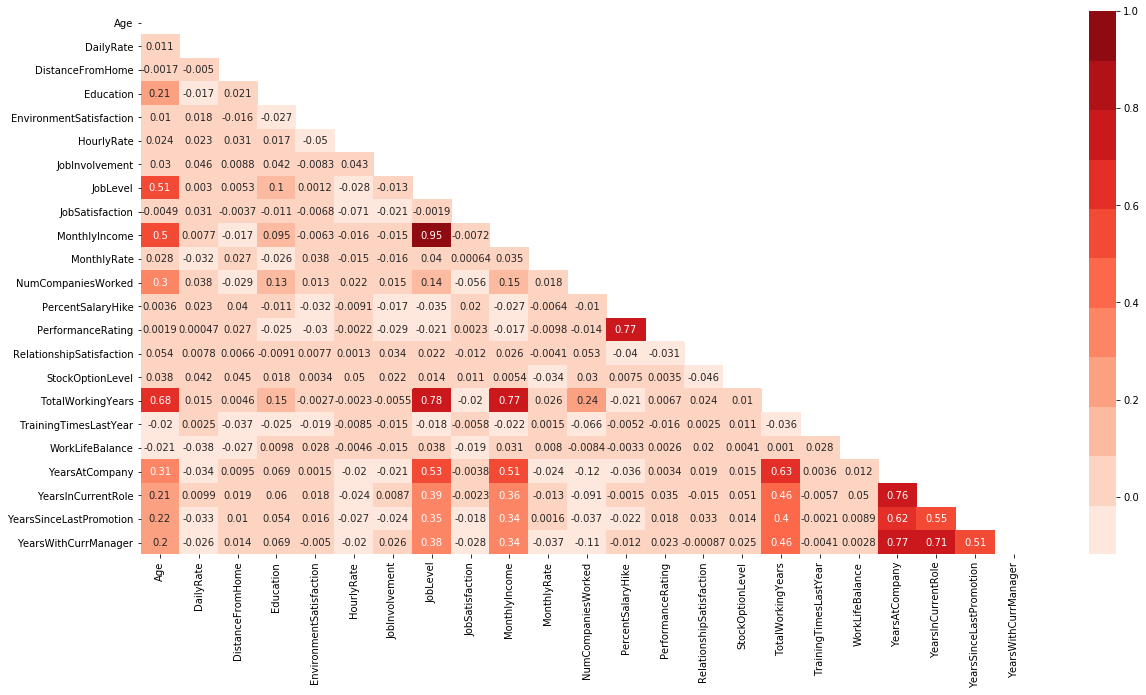

In [10]:
# I'm also removing these columns because they're either an ID or constant and have no variation
correlation = df.drop(["EmployeeCount", "EmployeeNumber", "StandardHours", "Salary hike above average"], axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(correlation, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(20,10))
sns.heatmap(correlation, annot = True, cmap = sns.color_palette("Reds", 11), mask = mask)
plt.show()

This heatmap says alot about the company:

1. Higher lob levels means higher monthly incomes (which is obvious)

2. Theres a strong correlation between the number of years at the company and the number of years with a given manager and role, meaning that people in this company don't often change managers/roles

3. People with higher performance ratings receive higher salary hikes (which is also obvious) but when we contrast this with the previous plot where we say there where a lot of leavers with above average salary hikes, we get the sense that many of our leavers are have a good performance, which aggravates the cost of employee attrition

Lets move on to a different analysis other than visualizations and let's which variables have a greater impact in our outcome variable through means of feature selection

# 2. Feature Selection

We'll be using a univariate filter. What this means is that for every variable we'll do a univariate statistical test and determine wether the variable is relevant to predict leaving employees or not. First we'll one-hot encode the necessary features and scale everything

Some features don't need to be one-hot encoded as they have a sense of order to them (like Education or  PerformanceRating) so we wount one-hot encode these features

In [11]:
#Lets deal with the categorical cloumns now
# simply change yes/no to 1/0 for Attrition, Gender, OverTime
df['Attrition'].replace({'No': 0, 'Yes': 1},inplace = True)
df['Gender'].replace({'Male': 0, 'Female': 1},inplace = True)
df['OverTime'].replace({'No': 0, 'Yes': 1},inplace = True)

# specifying names of categorical columns to be one-hot encoded
categorical_columns = ['BusinessTravel', 'Department', 'EducationField', "JobRole", "MaritalStatus"]

# transform the categorical columns
df = pd.get_dummies(df, columns=categorical_columns)
df.head()

Age  Attrition  DailyRate  DistanceFromHome  Education  EmployeeCount  \
0   41          1       1102                 1          2              1   
1   49          0        279                 8          1              1   
2   37          1       1373                 2          2              1   
3   33          0       1392                 3          4              1   
4   27          0        591                 2          1              1   

   EmployeeNumber  EnvironmentSatisfaction  Gender  HourlyRate  ...  \
0               1                        2       1          94  ...   
1               2                        3       0          61  ...   
2               4                        4       0          92  ...   
3               5                        4       1          56  ...   
4               7                        1       0          40  ...   

   JobRole_Laboratory Technician  JobRole_Manager  \
0                              0                0   
1                              0                0   
2                              1                0   
3                              0                0   
4                              1                0   

   JobRole_Manufacturing Director  JobRole_Research Director  \
0                               0                          0   
1                               0                          0   
2                               0                          0   
3                               0                          0   
4                               0                          0   

   JobRole_Research Scientist  JobRole_Sales Executive  \
0                           0                        1   
1                           1                        0   
2                           0                        0   
3                           1                        0   
4                           0                        0   

  JobRole_Sales Representative  MaritalStatus_Divorced  MaritalStatus_Married  \
0                            0                       0                      0   
1                            0                       0                      1   
2                            0                       0                      0   
3                            0                       0                      1   
4                            0                       0                      1   

   MaritalStatus_Single  
0                     1  
1                     0  
2                     1  
3                     0  
4                     0  

[5 rows x 55 columns]

In [12]:
# Removing unecessary features
df.drop(["EmployeeNumber", "EmployeeCount", "Over18", "Salary hike above average", "StandardHours"], axis = 1, inplace = True)

# Instanciate MinMaxScaler 
scaler = MinMaxScaler()

# Create a new dataframe with the scaled features
df = pd.DataFrame(scaler.fit_transform(df), index = df.index, columns = df.columns)
df.head()

Age  Attrition  DailyRate  DistanceFromHome  Education  \
0  0.547619        1.0   0.715820          0.000000       0.25   
1  0.738095        0.0   0.126700          0.250000       0.00   
2  0.452381        1.0   0.909807          0.035714       0.25   
3  0.357143        0.0   0.923407          0.071429       0.75   
4  0.214286        0.0   0.350036          0.035714       0.00   

   EnvironmentSatisfaction  Gender  HourlyRate  JobInvolvement  JobLevel  ...  \
0                 0.333333     1.0    0.914286        0.666667      0.25  ...   
1                 0.666667     0.0    0.442857        0.333333      0.25  ...   
2                 1.000000     0.0    0.885714        0.333333      0.00  ...   
3                 1.000000     1.0    0.371429        0.666667      0.00  ...   
4                 0.000000     0.0    0.142857        0.666667      0.00  ...   

   JobRole_Laboratory Technician  JobRole_Manager  \
0                            0.0              0.0   
1                            0.0              0.0   
2                            1.0              0.0   
3                            0.0              0.0   
4                            1.0              0.0   

   JobRole_Manufacturing Director  JobRole_Research Director  \
0                             0.0                        0.0   
1                             0.0                        0.0   
2                             0.0                        0.0   
3                             0.0                        0.0   
4                             0.0                        0.0   

   JobRole_Research Scientist  JobRole_Sales Executive  \
0                         0.0                      1.0   
1                         1.0                      0.0   
2                         0.0                      0.0   
3                         1.0                      0.0   
4                         0.0                      0.0   

   JobRole_Sales Representative  MaritalStatus_Divorced  \
0                           0.0                     0.0   
1                           0.0                     0.0   
2                           0.0                     0.0   
3                           0.0                     0.0   
4                           0.0                     0.0   

   MaritalStatus_Married  MaritalStatus_Single  
0                    0.0                   1.0  
1                    1.0                   0.0  
2                    0.0                   1.0  
3                    1.0                   0.0  
4                    1.0                   0.0  

[5 rows x 50 columns]

MinMaxScaler makes sure that every feature values ranges from 0 to 1 so that there's no discrepancy in the different feature scales, this scaler does not, however, handle outliers so that might be something we should watch out for and maybe correct with a different scaler, but I don't think it'll be worth the hassle.

Now that we have our features cleaned up we can perform our feature selection test

In [13]:
# specify our x and y variables
x, y = df.drop(["Attrition"], axis = 1), df.Attrition

# instantiate our selector to select the top 10 features
selector = SelectKBest(f_classif, k = 10)

# fit our selector to the data
selector.fit(x, y)

# see what are the top selected features from our univariate filter
x.columns[selector.get_support(indices = True)]

Index(['Age', 'JobLevel', 'MonthlyIncome', 'OverTime', 'StockOptionLevel',
       'TotalWorkingYears', 'YearsInCurrentRole', 'YearsWithCurrManager',
       'JobRole_Sales Representative', 'MaritalStatus_Single'],
      dtype='object')

We previously saw that only a small portion of stayers actually worked overtime so it's no surprise it was selected.
The remaning features are pretty obvious to and one can hypothesize that a leaver is a person who works **OverTime** is **Single**, has spent alot of time in the same **Role** which is probably **Sales Representative**, probably hasn't worked in the company for very long and has a low **JobLevel**, has a lower **Age**, has no **StockOptionLevel** and has a lower **MonthlyIncome**. Of course this only of the top of my head but at least we have an ANOVA test to back our findings :)

Since we don't have many observations in our dataset, having too many features like we do might prove the learning process dificult, and so selecting features this way may be beneficial!
We can test a model using all variables and one model using only this selected variables.

# 3. Modeling